# Neural States Analysis

'''Created on Fri 16 April 2021'''

Will here explore the posibility that some particular states pops out from the activity traces and look at the correspondient behaviour using the segmentation of activity from DLC.

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 32363         ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
session_now = 1
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/tracking/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'

In [4]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
total_time = 0
day = 0
for trial in [1,6,11,16]:
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)
    
    behaviour_list.append(resample_beh1)
    total_time = total_time + behaviour.shape[0]
    
    
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = sstats.zscore(neural_activity1)
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    day = day + 1

In [5]:
## define targets of behaviour according to protocol (random, overlapping and stable)

id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2

if colapse_behaviour == 0 : # RANDOM
    for day in range(len(behaviour_list)):
        for trial in range(5):
            behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
            objects = np.unique(behaviour_trial)
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_trial==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
            behaviour_trial[index0] = 3
            behaviour_trial[index1] = 4
            behaviour_trial[index2] = 4            
            
            index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
            behaviour_trial[index0] = 5
            behaviour_trial[index1] = 6
            behaviour_trial[index2] = 6 
            
            behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


if colapse_behaviour == 1 : #OVERLAPPING
    for day in range(len(behaviour_list)):
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
        behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 6
        behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 5        


if colapse_behaviour == 2: #STABLE
    for day in range(len(behaviour_list)):
        objects = np.unique(behaviour_list[day])
        selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
        index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
        behaviour_list[day][index0] = 3
        behaviour_list[day][index1] = 4
        behaviour_list[day][index2] = 4      
    
        index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
        behaviour_list[day][index0] = 5
        behaviour_list[day][index1] = 6
        behaviour_list[day][index2] = 6  

In [6]:
# we compute for each day a matrix containing all the activity
matrix_elements_size= []
neural_corr = []
temporal_corr = []
mean_activity = []
for day in range(len(activity_list)):
    mean_over_trials =  np.mean(activity_list[day], axis= 1)            
    mean_activity.append(mean_over_trials)
    
    matrix_elements_size.append(activity_list[day].shape)
    
    corr_matrix = stats.corr_matrix(neural_activity = activity_list[day])
    neural_corr.append(corr_matrix)
    
    corr_matrix2= stats.corr_matrix(neural_activity = activity_list[day].T)
    temporal_corr.append(corr_matrix2)
    

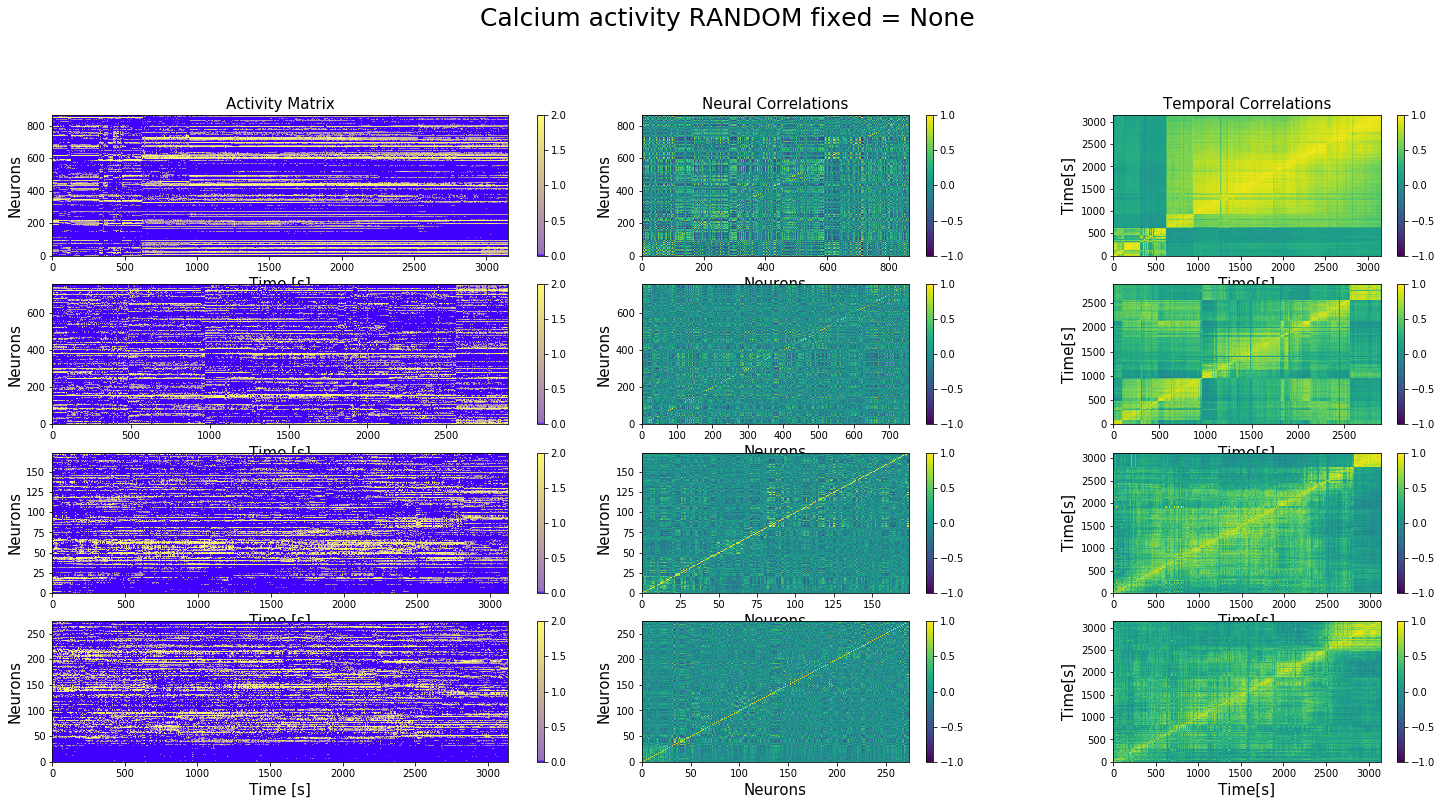

In [7]:
import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

vmin= 0
vmax=2

vmin_corr= -1
vmax_corr=1

fig = plt.figure()
gs = plt.GridSpec(5,12)

i=0
for day in range(len(activity_list)):
    ax = fig.add_subplot(gs[day,0:5])
    #ax.set_title()
    ax.set_ylabel('Neurons', fontsize = 15)
    ax.set_xlabel('Time [s]', fontsize = 15)
    mesh = ax.pcolormesh(activity_list[day], cmap = cm)
    mesh.set_clim(vmin,vmax)
    fig.colorbar(mesh,ax=ax)
    if day == 0:
        ax.set_title('Activity Matrix', fontsize = 15)
    
        
    ax = fig.add_subplot(gs[day, 5:8])
    ax.set_ylabel('Neurons', fontsize = 15)
    ax.set_xlabel('Neurons', fontsize = 15)
    mesh = ax.pcolormesh(neural_corr[day], cmap = 'viridis')
    mesh.set_clim(vmin_corr,vmax_corr)
    fig.colorbar(mesh,ax=ax)
    if day == 0:
        ax.set_title('Neural Correlations', fontsize = 15)
      
        
    ax = fig.add_subplot(gs[day, 9:12])
    ax.set_ylabel('Time[s]', fontsize = 15)
    ax.set_xlabel('Time[s]', fontsize = 15)
    mesh = ax.pcolormesh(temporal_corr[day], cmap = 'viridis')
    mesh.set_clim(vmin_corr,vmax_corr)
    fig.colorbar(mesh,ax=ax)
    if day == 0:
        ax.set_title('Temporal Correlations', fontsize = 15)
    
    
#fig.tight_layout()
fig.set_size_inches(25,15)
fig.suptitle('Calcium activity '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'calcium_activity_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

In [8]:
### compute pca ver matrix of different days
neural_pca_components= []
neural_explained_variance = []
neural_transform=[]
neural_pca = PCA()

temporal_pca = PCA()
data_transform = []
temporal_explained_variance = []
temporal_pca_components= []


for i in range(len(activity_list)):
    neural_pca.fit(activity_list[i].T)
    neural_pca_components.append(neural_pca.components_)
    neural_transform.append(neural_pca.transform(activity_list[i].T))
    neural_explained_variance.append(neural_pca.explained_variance_ratio_)
    
    temporal_pca.fit(activity_list[i])
    data_transform.append(temporal_pca.transform(activity_list[i]))
    temporal_explained_variance.append(temporal_pca.explained_variance_ratio_)
    temporal_pca_components.append(temporal_pca.components_)

### Temporal correlations

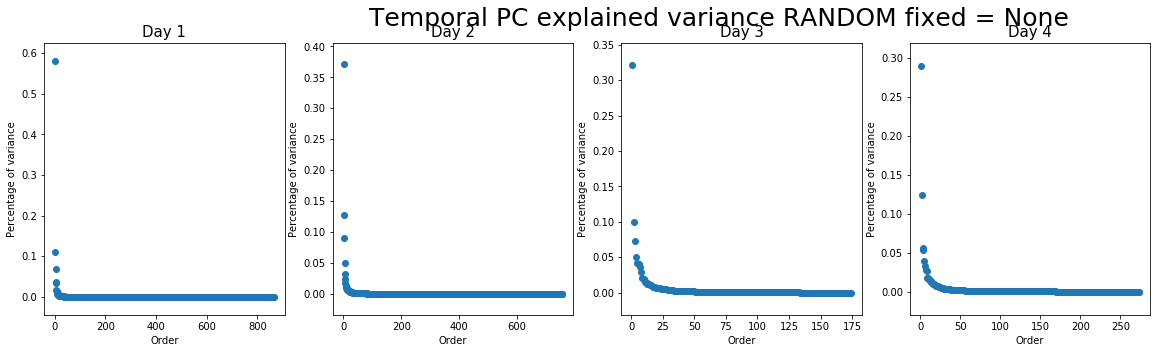

In [9]:
## plot explained variance for each day

fig = plt.figure()
gs = plt.GridSpec(1,5)

for day in range(len(temporal_explained_variance)): 
    ax = fig.add_subplot(gs [0,day])
    ax.scatter(np.arange(1,len(temporal_explained_variance[day])+1,1),temporal_explained_variance[day])
    ax.set_title('Day ' + f'{day+1}', fontsize = 15)
    ax.set_xlabel('Order')
    ax.set_ylabel('Percentage of variance')
fig.set_size_inches(25,5)
fig.suptitle('Temporal PC explained variance '+ task + ' fixed = ' + fixed  , fontsize = 25)
figure_name = figure_path +'temporal_pcs_explained_variance_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

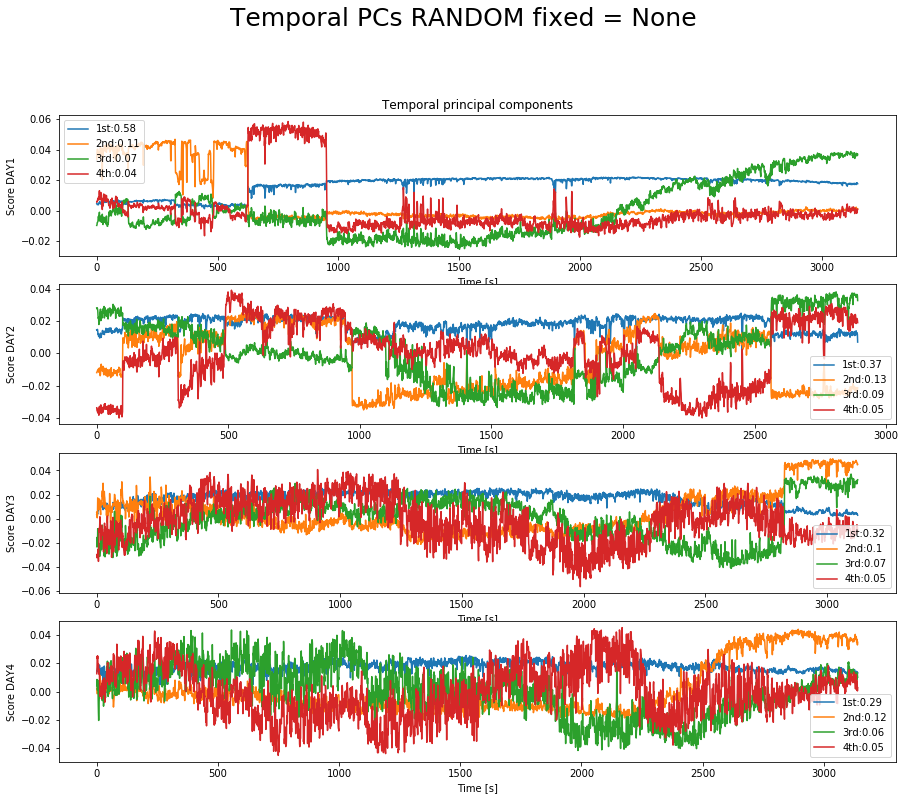

In [10]:
fig = plt.figure()
gs = plt.GridSpec(5, 1)
comp= ['1st','2nd','3rd','4th']


vmin= 0
vmax=1.75

for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0])
    
    ax.plot(temporal_pca_components[day][0,:] / np.linalg.norm(temporal_pca_components[day][0,:]))
    ax.plot(temporal_pca_components[day][1,:] / np.linalg.norm(temporal_pca_components[day][1,:]))
    ax.plot(temporal_pca_components[day][2,:] / np.linalg.norm(temporal_pca_components[day][2,:]))
    ax.plot(temporal_pca_components[day][3,:] / np.linalg.norm(temporal_pca_components[day][3,:]))

    ax.legend([comp[0] + ':' + f'{round(temporal_explained_variance[day][0],2)}', 
               comp[1] + ':' + f'{round(temporal_explained_variance[day][1],2)}',
              comp[2] + ':' + f'{round(temporal_explained_variance[day][2],2)}',
              comp[3] + ':' + f'{round(temporal_explained_variance[day][3],2)}'])
    if day == 0:
        ax.set_title('Temporal principal components')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Score DAY' + f'{day+1}' )
    #ax.set_ylim([-0.1, 0.35])
    
    

#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle('Temporal PCs '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'temporal_componets_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

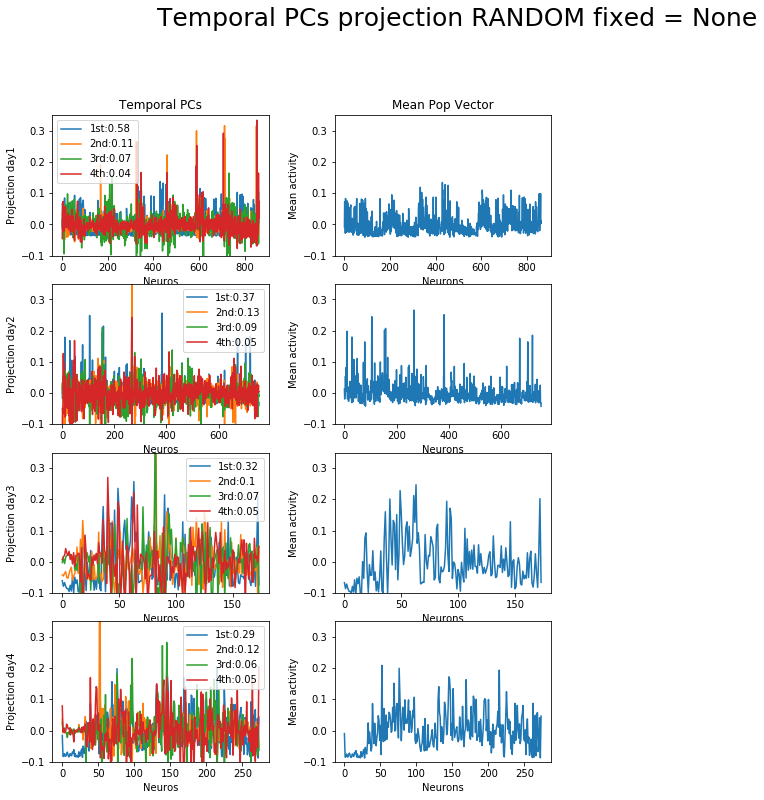

In [11]:
fig = plt.figure()
gs = plt.GridSpec(5, 15)
comp= ['1st','2nd','3rd','4th']


vmin= 0
vmax=1.75

for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0:4])
    
    ax.plot(data_transform[day][:,0]/np.linalg.norm(data_transform[day][:,0]))
    ax.plot(data_transform[day][:,1]/np.linalg.norm(data_transform[day][:,1]))
    ax.plot(data_transform[day][:,2]/np.linalg.norm(data_transform[day][:,2]))
    ax.plot(data_transform[day][:,3]/np.linalg.norm(data_transform[day][:,3]))    
    ax.legend([comp[0] + ':' + f'{round(temporal_explained_variance[day][0],2)}', 
               comp[1] + ':' + f'{round(temporal_explained_variance[day][1],2)}',
              comp[2] + ':' + f'{round(temporal_explained_variance[day][2],2)}',
              comp[3] + ':' + f'{round(temporal_explained_variance[day][3],2)}'])
    if day == 0:
        ax.set_title('Temporal PCs')
    ax.set_xlabel('Neuros')
    ax.set_ylabel('Projection day' + f'{day+1}' )
    ax.set_ylim([-0.1, 0.35])
    
    ax = fig.add_subplot(gs [day,5:9])
    ax.plot(mean_activity[day]/np.linalg.norm(mean_activity[day]))
    if day == 0:
        ax.set_title('Mean Pop Vector')
    ax.set_xlabel('Neurons')
    ax.set_ylabel('Mean activity')
    ax.set_ylim([-0.1, 0.35])
    

#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle('Temporal PCs projection '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'temporal_pcs_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

In [12]:
# compute distance between each temporal point in the activity matrix and the principal components that are computed
# with the eigenvector analysis

relevant_components = 10
distance_list = []
for day in range(len(activity_list)): 
    distance_matrix = np.zeros((activity_list[day].shape[1],relevant_components))
    for component in range(relevant_components):
        for i in range(activity_list[day].shape[1]):
            #distance = np.linalg.norm(data_transform[day][:,component]/np.linalg.norm(data_transform[day][:,component])-
            #                    activity_list[day][:,i]/np.linalg.norm(activity_list[day][:,i]))
            distance = np.dot(data_transform[day][:,component]/np.linalg.norm(data_transform[day][:,component]),
                             activity_list[day][:,i]/np.linalg.norm(activity_list[day][:,i]))
            distance_matrix[i,component] = distance
    distance_list.append(distance_matrix)

In [13]:
embedded_list = []
for day in range(len(activity_list)): 
    embedded_activity = TSNE(n_components=2, perplexity=30.0, n_iter=3000,).fit_transform(distance_list[day])
    embedded_list.append(embedded_activity)

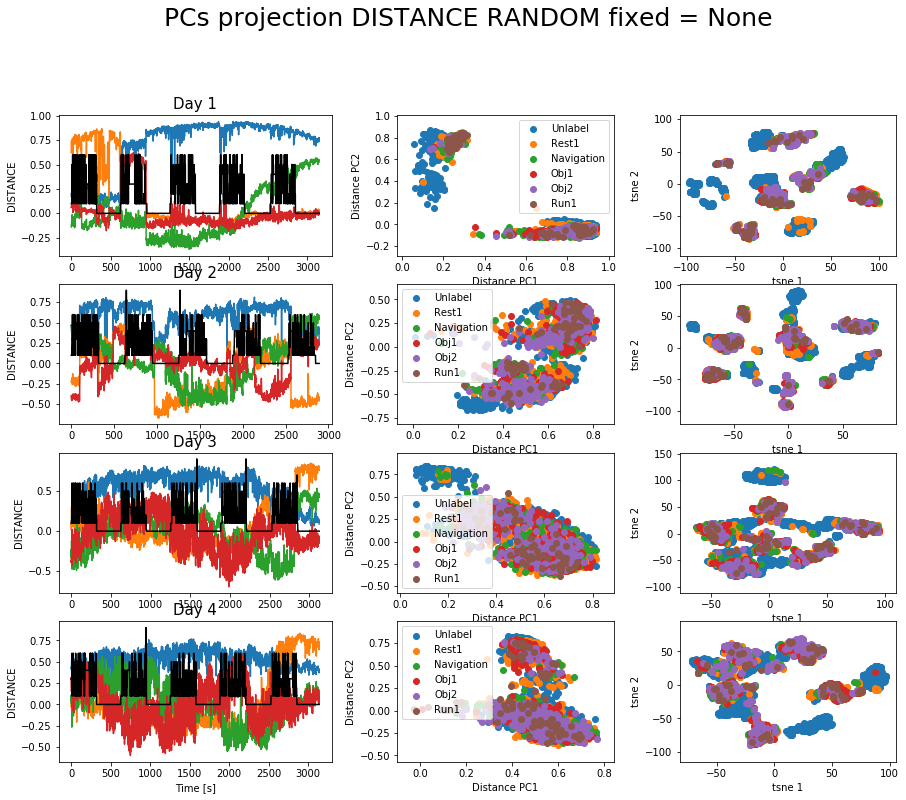

In [14]:
fig = plt.figure()
gs = plt.GridSpec(5, 15)
comp= ['1st','2nd','3rd','4th']

beh = labels
vmin= 0
vmax=1.75

for day in range(len(activity_list)): 
    #print(activity_list[day].shape[1])
    #print( behaviour_list[day].shape)
    
    ax = fig.add_subplot(gs[day,0:5])
    ax.plot(distance_list[day][:,0:4])
    ax.plot(behaviour_list[day]/10,'k')
    ax.set_title('Day ' + f'{day+1}', fontsize = 15 )
    if day == len(activity_list)-1:
        ax.set_xlabel('Time [s]')
    ax.set_ylabel('DISTANCE')
    
    ax = fig.add_subplot(gs[day,6:10])#,projection = '3d')
    behaviour_vector= behaviour_list[day].copy()
    #behaviour_vector[np.where(behaviour_vector>=2)]=2
    #print(distance_list[day].shape)
    #print(behaviour_vector.shape)
    for target in range(6):
        #print(target)
        ax.scatter(distance_list[day][np.where(behaviour_vector==target),0],
                  distance_list[day][np.where(behaviour_vector==target),1])#,
                  #distance_list[day][np.where(behaviour_list[day]==target),3])
            
    ax.legend(beh)
    ax.set_xlabel('Distance PC1')
    ax.set_ylabel('Distance PC2')
    
    ax = fig.add_subplot(gs[day,11:15])#,projection = '3d')
    for target in range(6):
        ax.scatter(embedded_list[day][np.where(behaviour_vector==target),0],
                  embedded_list[day][np.where(behaviour_vector==target),1])#,
                  #distance_list[day][np.where(behaviour_list[day]==target),3])
            
    #ax.legend(beh)
    ax.set_xlabel('tsne 1')
    ax.set_ylabel('tsne 2')
    
    
#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle(' PCs projection DISTANCE '+ task + ' fixed = ' + fixed  , fontsize = 25)


figure_name = figure_path +'temporal_pcs_with_behaviour_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)


In [15]:
### Neural Correlations

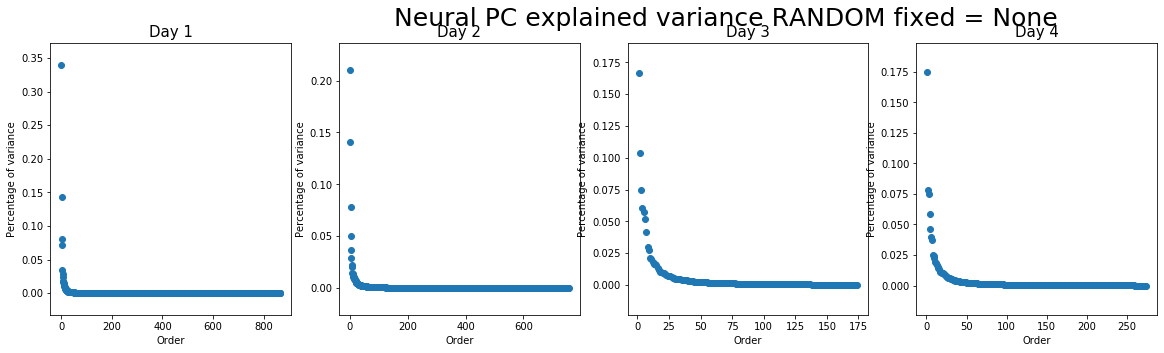

In [16]:
## plot explained variance for each day

fig = plt.figure()
gs = plt.GridSpec(1,5)

for day in range(len(neural_explained_variance)): 
    ax = fig.add_subplot(gs [0,day])
    ax.scatter(np.arange(1,len(neural_explained_variance[day])+1,1),neural_explained_variance[day])
    ax.set_title('Day ' + f'{day+1}', fontsize = 15)
    ax.set_xlabel('Order')
    ax.set_ylabel('Percentage of variance')
fig.set_size_inches(25,5)
fig.suptitle('Neural PC explained variance '+ task + ' fixed = ' + fixed  , fontsize = 25)
figure_name = figure_path +'neural_pcs_explained_variance_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

In [17]:
# compute distance between each temporal point in the activity matrix and the principal components that are computed
# with the eigenvector analysis here with the eigenvectors directly (not the porjection as before)
relevant_components = 5
distance_list_2 = []
for day in range(len(activity_list)): 
    distance_matrix = np.zeros((activity_list[day].shape[1],relevant_components))
    for component in range(relevant_components):
        for i in range(activity_list[day].shape[1]):
            distance = np.linalg.norm(neural_pca_components[day][component,:]/np.linalg.norm(neural_pca_components[day][component,:])-
                                activity_list[day][:,i]/np.linalg.norm(activity_list[day][:,i]))
            distance_matrix[i,component] = distance
    distance_list_2.append(distance_matrix)

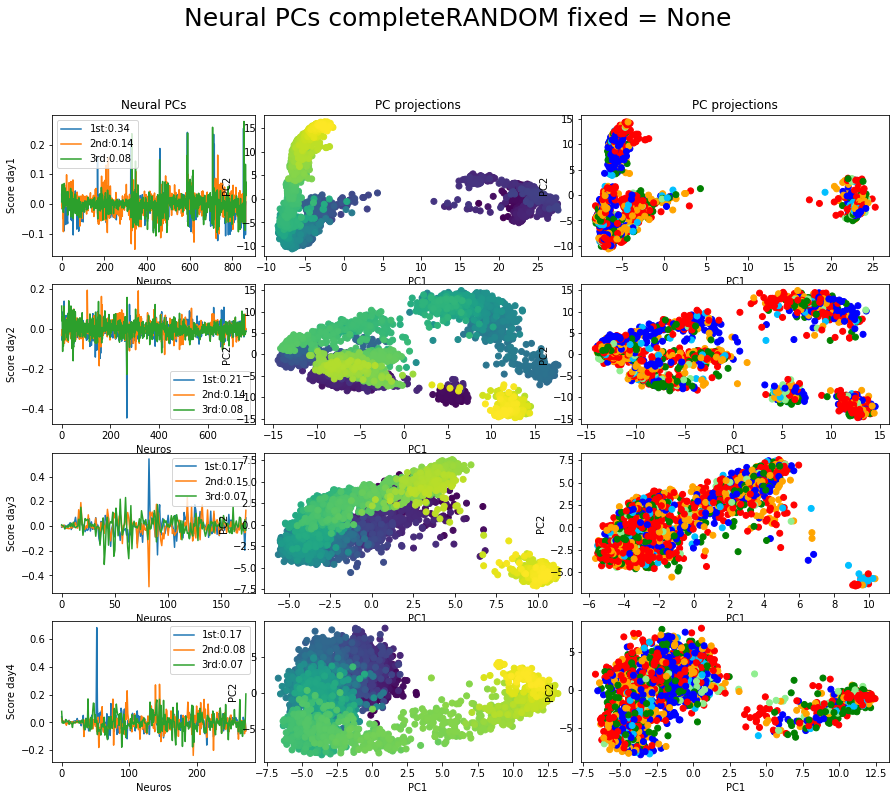

In [18]:
fig = plt.figure()
gs = plt.GridSpec(5, 16)

markers = ['o', '^', '*']
colornames=['k',"r","orange","g","blue","lightgreen","deepskyblue"]           


for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0:4])
    
    ax.plot(neural_pca_components[day][0,:]/np.linalg.norm(neural_pca_components[day][0,:]))
    ax.plot(neural_pca_components[day][1,:]/np.linalg.norm(neural_pca_components[day][1,:]))
    ax.plot(neural_pca_components[day][2,:]/np.linalg.norm(neural_pca_components[day][2,:]))
   
    ax.legend([comp[0] + ':' + f'{round(neural_explained_variance[day][0],2)}', 
               comp[1] + ':' + f'{round(neural_explained_variance[day][1],2)}',
              comp[2] + ':' + f'{round(neural_explained_variance[day][2],2)}'])
    if day == 0:
        ax.set_title('Neural PCs')
    ax.set_xlabel('Neuros')
    ax.set_ylabel('Score day' + f'{day+1}' )
    #ax.set_ylim([-0.1, 0.35])
    
    ax = fig.add_subplot(gs [day,4:10])#, projection = '3d')
    
    #for beh in range(len(matrix_elements_size[day])):
    color1 = np.linspace(0, 20, len(neural_transform[day][:,0]))
    ax.scatter(neural_transform[day][:,0],
                neural_transform[day][:,1],
                #neural_transform[day][:,2],
                c = color1)
    
    #ax.legend(['Resting','Navigation','Exploration'])
    if day == 0:
        ax.set_title('PC projections')
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
    
    ax = fig.add_subplot(gs [day,10:16])#, projection = '3d')
    
    #for beh in range(len(matrix_elements_size[day])):
    beh_color = behaviour_list[day].copy()
    #beh_color[np.where(beh_color>=2)]=2
    relevant = np.where(np.logical_and(beh_color>0, beh_color<7))[0]
    color_new = []
    for k in range(len(relevant)):
        color_new.append(colornames[int(beh_color[relevant[k]])])
    ax.scatter(neural_transform[day][relevant,0],
                neural_transform[day][relevant,1],
                #neural_transform[day][:,2],
                c = color_new , cmap=cmap)
    
    #ax.legend(['Resting','Navigation','Exploration'])
    if day == 0:
        ax.set_title('PC projections')
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
#fig.tight_layout()
fig.set_size_inches(15,15)
    
#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle('Neural PCs complete'+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'neural_pcs_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)


Text(0.5, 0.98, 'Neural PCs completeRANDOM fixed = None')

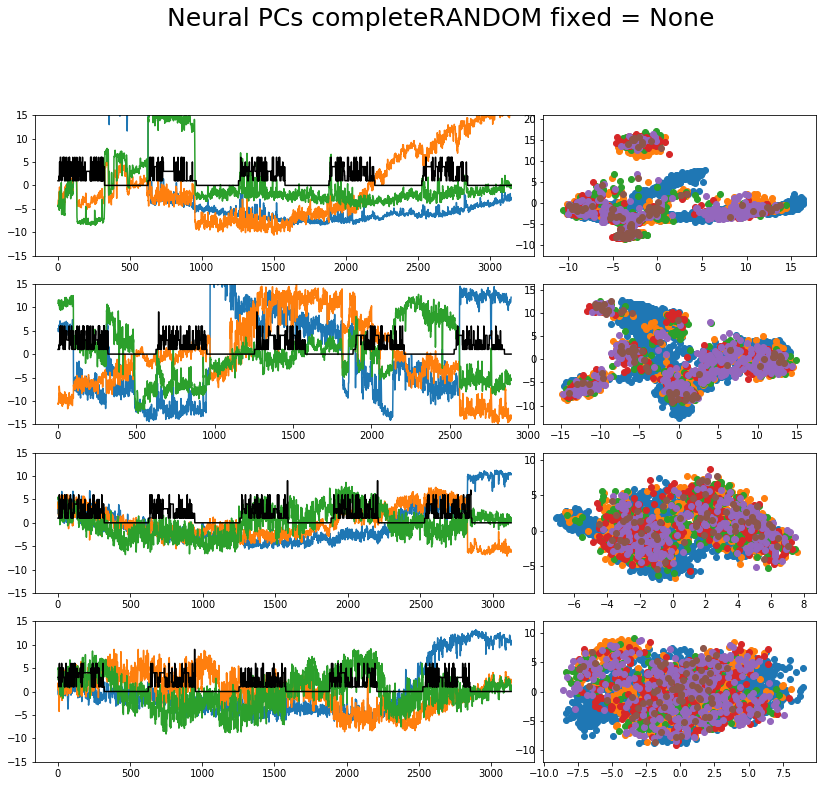

In [19]:
fig = plt.figure()
gs = plt.GridSpec(5, 15)

relevant_components = 3
for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0:9])
    #color1 = np.linspace(0, 20, len(neural_transform[day][:,0]))
    for i in range(relevant_components):
        ax.plot(neural_transform[day][:,i])
                #neural_transform[day][:,1],
                #neural_transform[day][:,2],
                #marker = markers[beh], c = color1)
    ax.plot(behaviour_list[day],'k')
        
    ax.set_ylim([-15, 15])

    
    ax = fig.add_subplot(gs[day,9:14])#,projection = '3d')
    behaviour_vector= behaviour_list[day].copy()
    #behaviour_vector[np.where(behaviour_vector>=2)]=2
    for target in range(6):
        ax.scatter(neural_transform[day][np.where(behaviour_vector==target)[0],1],
                  neural_transform[day][np.where(behaviour_vector==target)[0],2])
                  # neural_transform[day][np.where(behaviour_vector==target)[0],2] )#,
            
    
#fig.tight_layout()
fig.set_size_inches(15,15)
    
fig.suptitle('Neural PCs complete'+ task + ' fixed = ' + fixed  , fontsize = 25)

In [20]:
relevant_tsne_components = 10

In [21]:
embedded_list = []
for day in range(len(activity_list)): 
    embedded_activity = TSNE(n_components=2, perplexity=30.0, n_iter=3000,).fit_transform(neural_transform[day][:,0:relevant_tsne_components])
    embedded_list.append(embedded_activity)

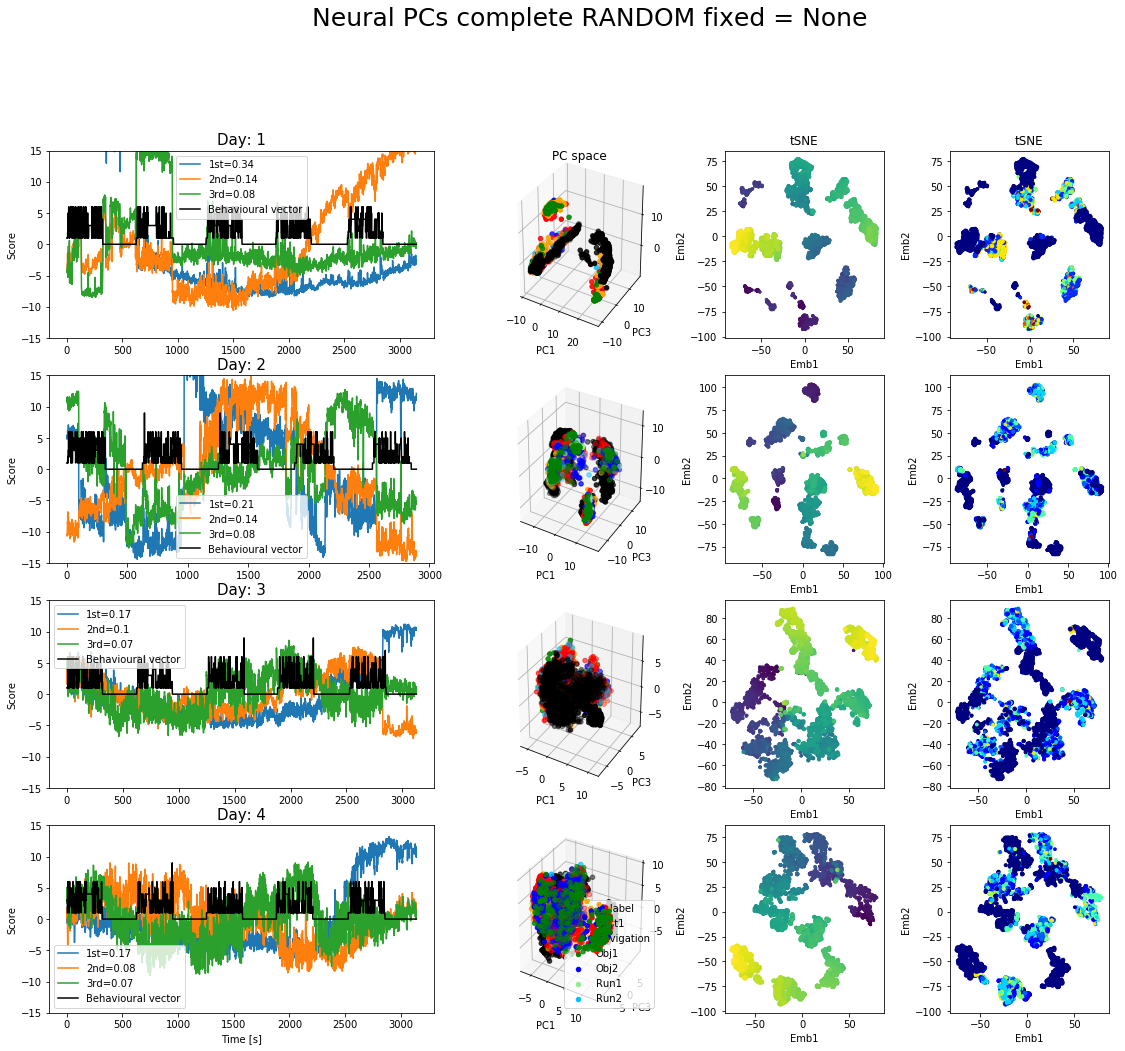

In [29]:
fig = plt.figure()
gs = plt.GridSpec(5, 20)

relevant_components = 3
for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0:7])
    for i in range(relevant_components):
        ax.plot(neural_transform[day][:,i])
                #neural_transform[day][:,1],
                #neural_transform[day][:,2],
                #marker = markers[beh], c = color1)
    ax.plot(behaviour_list[day],'k')
    ax.set_ylim([-15, 15])
    ax.set_ylabel('Score')
    ax.set_title('Day: '+ f'{day+1}', fontsize = 15)
    if day == len(activity_list)-1:
        ax.set_xlabel('Time [s]')
    ax.legend(['1st='+f'{round(neural_explained_variance[day][0],2)}',
               '2nd='+f'{round(neural_explained_variance[day][1],2)}',
              '3rd='+f'{round(neural_explained_variance[day][2],2)}',
             #  '4th='+f'{round(neural_explained_variance[day][3],2)}',
             # '5th='+f'{round(neural_explained_variance[day][4],2)}',
              'Behavioural vector'])

    ax = fig.add_subplot(gs[day,8:11],projection = '3d')
    
    beh_color = behaviour_list[day].copy()
    #beh_color[np.where(beh_color>=2)]=2 
    target_color = colornames
    for target in range(7):
        scatter_size = np.linspace(0,10,len(neural_transform[day][np.where(beh_color==target)[0],1]))
        ax.scatter(neural_transform[day][np.where(beh_color==target)[0],0],
                   neural_transform[day][np.where(beh_color==target)[0],1],
                   neural_transform[day][np.where(beh_color==target)[0],2],
                   scatter_size,
                   c = target_color[target])
                  # neural_transform[day][np.where(behaviour_vector==target)[0],2] )#,
    if day == 0:
        ax.set_title('PC space')
    if day ==3:
        ax.legend(labels)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_ylabel('PC3')    
    
    ax = fig.add_subplot(gs[day, 12:15])
    color = np.linspace(0, 20, embedded_list[day].shape[0])
    scatter_size = np.linspace(5,15,embedded_list[day].shape[0])
    ax.scatter(embedded_list[day][:,0],embedded_list[day][:,1], scatter_size,c=color)#, cmap=cmap)
    if day == 0:
        ax.set_title('tSNE')
    ax.set_xlabel('Emb1')
    ax.set_ylabel('Emb2')
    
    ax = fig.add_subplot(gs[day, 16:19])
    beh_color = behaviour_list[day].copy()
    #beh_color[np.where(beh_color>=2)]=2
    ax.scatter(embedded_list[day][:,0],embedded_list[day][:,1],  scatter_size, c=beh_color, cmap=cmap)
    if day == 0:
        ax.set_title('tSNE')
    ax.set_xlabel('Emb1')
    ax.set_ylabel('Emb2')
    
#fig.tight_layout()
fig.set_size_inches(20,20)
    
fig.suptitle('Neural PCs complete '+ task + ' fixed = ' + fixed  , fontsize = 25)


figure_name = figure_path +'neural_pcs_projection_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)